# Training Results Analysis: Validation Loss vs Behavioral Alignment

This notebook visualizes the relationship between validation loss and behavioral alignment across different training runs.


In [7]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import glob


In [11]:
# Set up paths and parameters
#results_dir = Path('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/clip_hba_behavior_loops/20251014_101100')
results_dir = Path('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/clip_hba_behavior_loops/20251015_092242')

# Find all training run directories
run_dirs = sorted([d for d in results_dir.glob('training_run*') if d.is_dir()],
                  key=lambda x: int(x.name.split('run')[1]))

print(f"Found {len(run_dirs)} training runs:")
for run_dir in run_dirs:
    print(f"  - {run_dir.name}")


Found 10 training runs:
  - training_run7
  - training_run13
  - training_run19
  - training_run25
  - training_run37
  - training_run49
  - training_run61
  - training_run73
  - training_run85
  - training_run98


In [12]:
# Load baseline data
baseline_csv = Path('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/clip_hba_behavior/training_results/training_res_20251013_220330.csv')
baseline_df = '/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/clip_hba_behavior/training_results/training_res_20251013_220330.csv'

if baseline_csv.exists():
    baseline_df = pd.read_csv(baseline_csv)
    baseline_df_clean = baseline_df.dropna(subset=['test_loss', 'behavioral_rsa_rho'])
    print(f"Baseline data loaded: {len(baseline_df_clean)} epochs")
else:
    print("Warning: Baseline data not found")

# Load data from all training runs
all_data = {}

for run_dir in run_dirs:
    run_name = run_dir.name
    run_num = run_name.split('run')[1]
    csv_file = run_dir / f"training_res_run{run_num}.csv"
    
    if csv_file.exists():
        df = pd.read_csv(csv_file)
        # Filter out rows with NaN values in the metrics we care about
        df_clean = df.dropna(subset=['test_loss', 'behavioral_rsa_rho'])
        
        if len(df_clean) > 0:
            all_data[run_name] = df_clean
            print(f"{run_name}: {len(df_clean)} epochs with valid data")
        else:
            print(f"{run_name}: No valid data found (all NaN)")
    else:
        print(f"{run_name}: CSV file not found")

print(f"\nTotal runs with valid data: {len(all_data)}")


Baseline data loaded: 118 epochs
training_run7: No valid data found (all NaN)
training_run13: No valid data found (all NaN)
training_run19: No valid data found (all NaN)
training_run25: No valid data found (all NaN)
training_run37: No valid data found (all NaN)
training_run49: No valid data found (all NaN)
training_run61: No valid data found (all NaN)
training_run73: No valid data found (all NaN)
training_run85: No valid data found (all NaN)
training_run98: 27 epochs with valid data

Total runs with valid data: 1


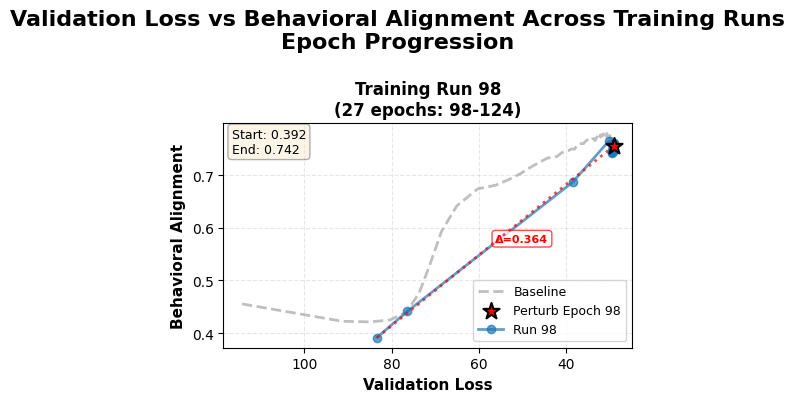

In [13]:
# Create multi-panel figure with separate subplot for each training run
n_runs = len(all_data)

# Determine grid layout (try to make it roughly square)
n_cols = int(np.ceil(np.sqrt(n_runs)))
n_rows = int(np.ceil(n_runs / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))

# Flatten axes array for easier indexing
if n_runs > 1:
    axes = axes.flatten()
else:
    axes = [axes]

# Use a consistent color scheme
colors = plt.cm.tab10(np.linspace(0, 1, 10))

for idx, (run_name, df) in enumerate(all_data.items()):
    ax = axes[idx]
    
    # Sort by epoch to ensure proper line connection
    df_sorted = df.sort_values('epoch')
    
    # Extract run number for title
    run_num = run_name.split('run')[1]
    perturb_epoch = int(run_num)
    
    # Plot baseline first if available
    baseline_at_perturb = None
    if baseline_df is not None:
        baseline_sorted = baseline_df_clean.sort_values('epoch')
        ax.plot(baseline_sorted['test_loss'], 
                baseline_sorted['behavioral_rsa_rho'],
                linestyle='--',
                linewidth=2,
                color='gray',
                alpha=0.5,
                label='Baseline',
                zorder=1)
        
        # Mark the perturbation epoch on the baseline
        baseline_at_perturb = baseline_df_clean[baseline_df_clean['epoch'] == perturb_epoch]
        if len(baseline_at_perturb) > 0:
            baseline_point = baseline_at_perturb.iloc[0]
            ax.scatter(baseline_point['test_loss'], 
                      baseline_point['behavioral_rsa_rho'],
                      s=150, 
                      color='red', 
                      marker='*',
                      edgecolors='black',
                      linewidth=1.5,
                      zorder=5,
                      label=f'Perturb Epoch {perturb_epoch}')
    
    # Plot perturbation run line with markers
    ax.plot(df_sorted['test_loss'], 
            df_sorted['behavioral_rsa_rho'],
            marker='o',
            markersize=6,
            linewidth=2,
            color=colors[idx % 10],
            alpha=0.7,
            label=f'Run {run_num}',
            zorder=2)
    
    # Connect the perturbation epoch on baseline to the corresponding epoch in perturbation run
    first_epoch = df_sorted.iloc[0]
    last_epoch = df_sorted.iloc[-1]
    
    if baseline_at_perturb is not None and len(baseline_at_perturb) > 0:
        # Draw connection line from baseline to perturbation run
        perturb_run_at_epoch = df_sorted[df_sorted['epoch'] == perturb_epoch]
        if len(perturb_run_at_epoch) > 0:
            perturb_point = perturb_run_at_epoch.iloc[0]
            ax.plot([baseline_point['test_loss'], perturb_point['test_loss']],
                   [baseline_point['behavioral_rsa_rho'], perturb_point['behavioral_rsa_rho']],
                   color='red',
                   linestyle=':',
                   linewidth=2,
                   alpha=0.7,
                   zorder=4)
            
            # Add annotation showing the divergence
            mid_x = (baseline_point['test_loss'] + perturb_point['test_loss']) / 2
            mid_y = (baseline_point['behavioral_rsa_rho'] + perturb_point['behavioral_rsa_rho']) / 2
            divergence = abs(baseline_point['behavioral_rsa_rho'] - perturb_point['behavioral_rsa_rho'])
            ax.annotate(f'Δ={divergence:.3f}',
                       xy=(mid_x, mid_y),
                       fontsize=8,
                       color='red',
                       fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='red'))
    
    # ax.annotate(f"Epoch {int(first_epoch['epoch'])}", 
    #             xy=(first_epoch['test_loss'], first_epoch['behavioral_rsa_rho']),
    #             xytext=(10, 10), textcoords='offset points',
    #             fontsize=9, alpha=0.7,
    #             bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3),
    #             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', alpha=0.5))
    
    # ax.annotate(f"Epoch {int(last_epoch['epoch'])}", 
    #             xy=(last_epoch['test_loss'], last_epoch['behavioral_rsa_rho']),
    #             xytext=(10, -10), textcoords='offset points',
    #             fontsize=9, alpha=0.7,
    #             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.3),
    #             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', alpha=0.5))
    
    # Formatting
    ax.set_xlabel('Validation Loss', fontsize=11, fontweight='bold')
    ax.set_ylabel('Behavioral Alignment', fontsize=11, fontweight='bold')
    ax.set_title(f'Training Run {run_num}\n({len(df_sorted)} epochs: {int(df_sorted["epoch"].min())}-{int(df_sorted["epoch"].max())})', 
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='best', fontsize=9, framealpha=0.8)
    
    # Flip x-axis so loss goes from high to low
    ax.invert_xaxis()
    
    # Add summary text
    summary_text = f"Start: {first_epoch['behavioral_rsa_rho']:.3f}\nEnd: {last_epoch['behavioral_rsa_rho']:.3f}"
    ax.text(0.02, 0.98, summary_text, transform=ax.transAxes,
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# Hide any unused subplots
for idx in range(n_runs, len(axes)):
    axes[idx].set_visible(False)

# Add overall title
fig.suptitle('Validation Loss vs Behavioral Alignment Across Training Runs\nEpoch Progression', 
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()


In [5]:
# Print summary statistics for all runs
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60 + "\n")

# Print baseline statistics first
if baseline_df is not None:
    baseline_sorted = baseline_df_clean.sort_values('epoch')
    print("BASELINE (No Perturbations):")
    print(f"  Epochs: {baseline_df_clean['epoch'].min():.0f} - {baseline_df_clean['epoch'].max():.0f} ({len(baseline_df_clean)} total)")
    print(f"  Validation Loss:")
    print(f"    Range: {baseline_df_clean['test_loss'].min():.2f} - {baseline_df_clean['test_loss'].max():.2f}")
    print(f"    Initial: {baseline_sorted.iloc[0]['test_loss']:.2f}")
    print(f"    Final: {baseline_sorted.iloc[-1]['test_loss']:.2f}")
    print(f"  Behavioral Alignment:")
    print(f"    Range: {baseline_df_clean['behavioral_rsa_rho'].min():.4f} - {baseline_df_clean['behavioral_rsa_rho'].max():.4f}")
    print(f"    Initial: {baseline_sorted.iloc[0]['behavioral_rsa_rho']:.4f}")
    print(f"    Final: {baseline_sorted.iloc[-1]['behavioral_rsa_rho']:.4f}")
    print(f"    Change: {(baseline_sorted.iloc[-1]['behavioral_rsa_rho'] - baseline_sorted.iloc[0]['behavioral_rsa_rho']):.4f}")
    print("\n" + "-"*60 + "\n")

for run_name, df in all_data.items():
    run_num = run_name.split('run')[1]
    df_sorted = df.sort_values('epoch')
    
    print(f"Training Run {run_num} (Perturbed at epoch {run_num}):")
    print(f"  Epochs: {df['epoch'].min():.0f} - {df['epoch'].max():.0f} ({len(df)} total)")
    print(f"  Validation Loss:")
    print(f"    Range: {df['test_loss'].min():.2f} - {df['test_loss'].max():.2f}")
    print(f"    Final: {df_sorted.iloc[-1]['test_loss']:.2f}")
    print(f"  Behavioral Alignment:")
    print(f"    Range: {df['behavioral_rsa_rho'].min():.4f} - {df['behavioral_rsa_rho'].max():.4f}")
    print(f"    Initial: {df_sorted.iloc[0]['behavioral_rsa_rho']:.4f}")
    print(f"    Final: {df_sorted.iloc[-1]['behavioral_rsa_rho']:.4f}")
    print(f"    Change: {(df_sorted.iloc[-1]['behavioral_rsa_rho'] - df_sorted.iloc[0]['behavioral_rsa_rho']):.4f}")
    
    # Compare to baseline at same epoch if available
    if baseline_df is not None:
        perturb_epoch = int(run_num)
        baseline_at_perturb = baseline_df_clean[baseline_df_clean['epoch'] == perturb_epoch]
        if len(baseline_at_perturb) > 0:
            baseline_ba = baseline_at_perturb.iloc[0]['behavioral_rsa_rho']
            final_ba = df_sorted.iloc[-1]['behavioral_rsa_rho']
            print(f"  Comparison to baseline at perturbation epoch {perturb_epoch}:")
            print(f"    Baseline BA: {baseline_ba:.4f}")
            print(f"    Final BA after recovery: {final_ba:.4f}")
            print(f"    Difference: {(final_ba - baseline_ba):.4f}")
    print()



SUMMARY STATISTICS

BASELINE (No Perturbations):
  Epochs: 1 - 118 (118 total)
  Validation Loss:
    Range: 29.10 - 114.27
    Initial: 114.27
    Final: 29.31
  Behavioral Alignment:
    Range: 0.4213 - 0.7790
    Initial: 0.4554
    Final: 0.7475
    Change: 0.2921

------------------------------------------------------------

Training Run 1 (Perturbed at epoch 1):
  Epochs: 1 - 118 (118 total)
  Validation Loss:
    Range: 29.15 - 119.22
    Final: 29.34
  Behavioral Alignment:
    Range: 0.4268 - 0.7852
    Initial: 0.4326
    Final: 0.7634
    Change: 0.3308
  Comparison to baseline at perturbation epoch 1:
    Baseline BA: 0.4554
    Final BA after recovery: 0.7634
    Difference: 0.3080

Training Run 4 (Perturbed at epoch 4):
  Epochs: 4 - 118 (115 total)
  Validation Loss:
    Range: 29.10 - 85.41
    Final: 29.30
  Behavioral Alignment:
    Range: 0.4422 - 0.7796
    Initial: 0.5004
    Final: 0.7479
    Change: 0.2475
  Comparison to baseline at perturbation epoch 4:
    Ba


Creating Behavioral Alignment Heatmap

Epoch range: 1 - 128
Training runs: [1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55, 61, 67, 73, 79, 85, 91, 98]
Total runs: 26



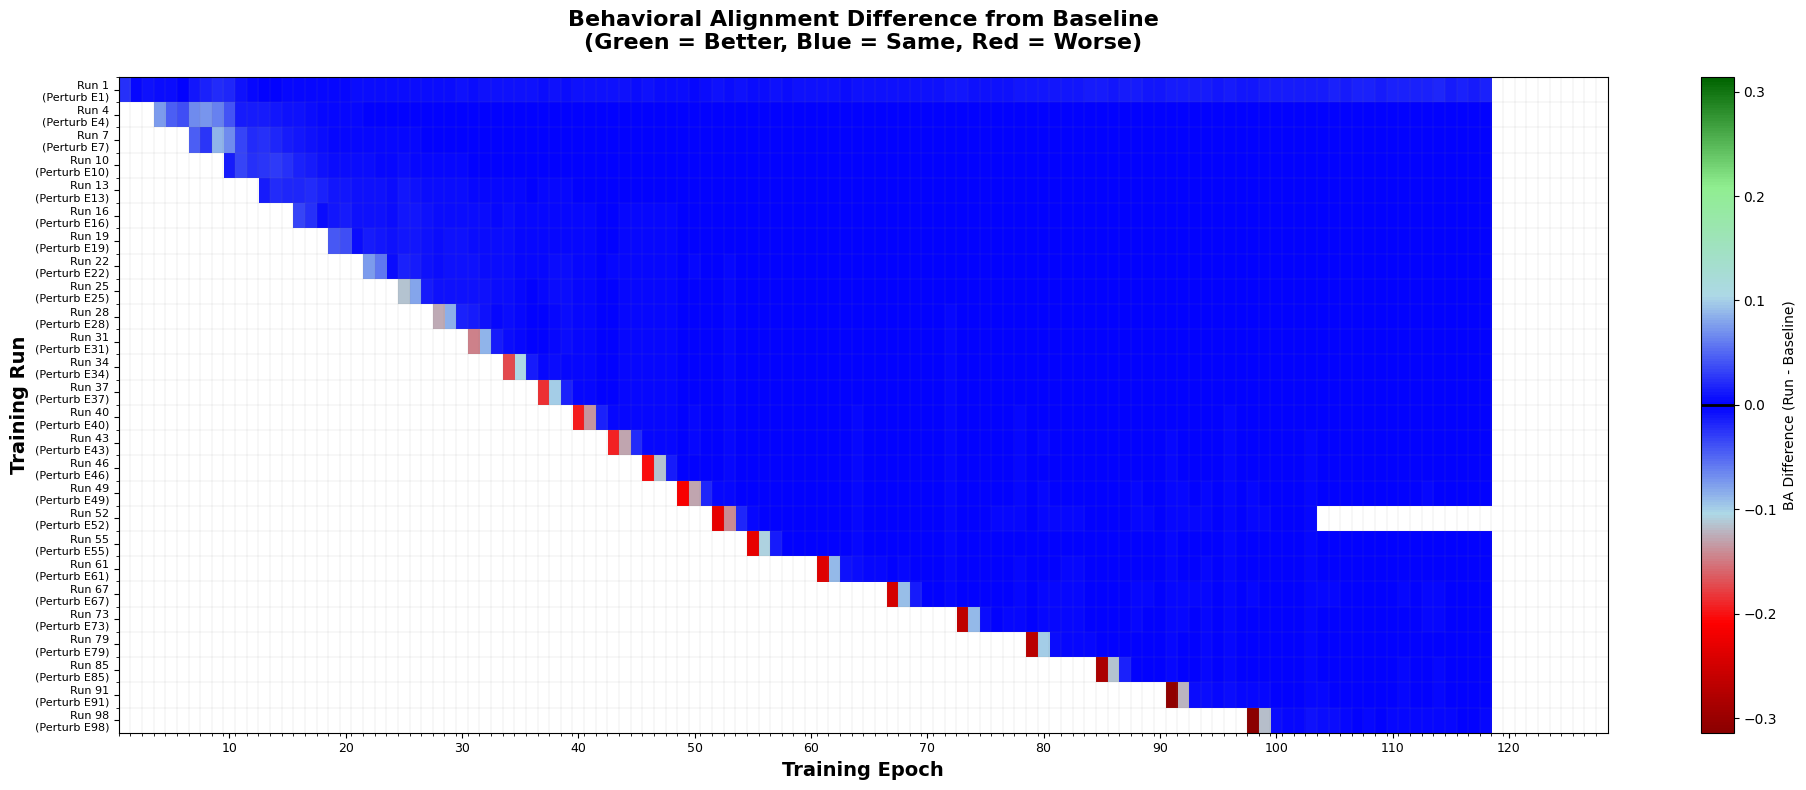


Heatmap Statistics:
  Max positive difference (better than baseline): 0.0754
  Max negative difference (worse than baseline): -0.3140
  Mean absolute difference: 0.0059
  Percentage of cells with data: 59.9%


In [6]:
# Heatmap: Behavioral Alignment Difference from Baseline across Epochs and Training Runs
print("\n" + "="*60)
print("Creating Behavioral Alignment Heatmap")
print("="*60 + "\n")

# Determine the range of epochs across all runs
all_epochs = set()
run_numbers = []

for run_name in all_data.keys():
    run_num = int(run_name.split('run')[1])
    run_numbers.append(run_num)
    all_epochs.update(all_data[run_name]['epoch'].values)

# Add baseline epochs
if baseline_df is not None:
    all_epochs.update(baseline_df_clean['epoch'].values)

min_epoch = int(min(all_epochs))
max_epoch = int(max(all_epochs))
epoch_range = list(range(min_epoch, max_epoch + 1))

print(f"Epoch range: {min_epoch} - {max_epoch}")
print(f"Training runs: {sorted(run_numbers)}")
print(f"Total runs: {len(run_numbers)}\n")

# Create a matrix: rows = training runs, columns = epochs
# Values = difference from baseline BA (positive = better than baseline, negative = worse)
run_numbers_sorted = sorted(run_numbers)
heatmap_data = np.full((len(run_numbers_sorted), len(epoch_range)), np.nan)

# Fill in the heatmap data
for i, run_num in enumerate(run_numbers_sorted):
    run_name = f"training_run{run_num}"
    if run_name in all_data:
        df = all_data[run_name]
        for _, row in df.iterrows():
            epoch = int(row['epoch'])
            if epoch in epoch_range:
                epoch_idx = epoch_range.index(epoch)
                
                # Get baseline BA at this epoch
                if baseline_df is not None:
                    baseline_at_epoch = baseline_df_clean[baseline_df_clean['epoch'] == epoch]
                    if len(baseline_at_epoch) > 0:
                        baseline_ba = baseline_at_epoch.iloc[0]['behavioral_rsa_rho']
                        run_ba = row['behavioral_rsa_rho']
                        
                        # Calculate difference (run - baseline)
                        heatmap_data[i, epoch_idx] = run_ba - baseline_ba

# Create the heatmap
fig, ax = plt.subplots(figsize=(20, max(8, len(run_numbers_sorted) * 0.3)))

# Create a custom colormap with a narrow blue region at zero
# This makes deviations from baseline more apparent
from matplotlib.colors import LinearSegmentedColormap
colors_positions = [
    (0.0, 'darkred'),      # Minimum (worst)
    (0.45, 'red'),         # Approaching zero from below
    (0.48, 'lightblue'),   # Just below zero
    (0.50, 'blue'),        # Exactly zero (baseline)
    (0.52, 'lightblue'),   # Just above zero
    (0.55, 'lightgreen'),  # Approaching from above
    (1.0, 'darkgreen')     # Maximum (best)
]
n_bins = 256
cmap = LinearSegmentedColormap.from_list('custom_narrow_diverging', 
                                         [c for _, c in colors_positions], 
                                         N=n_bins)

# Use a diverging colormap centered at 0
# Positive (green) = better than baseline, Negative (red) = worse than baseline, Zero (blue) = same as baseline
vmax = max(abs(np.nanmin(heatmap_data)), abs(np.nanmax(heatmap_data))) if not np.all(np.isnan(heatmap_data)) else 0.1
im = ax.imshow(heatmap_data, cmap=cmap, aspect='auto', vmin=-vmax, vmax=vmax, interpolation='nearest')

# Set ticks and labels
ax.set_yticks(range(len(run_numbers_sorted)))
ax.set_yticklabels([f'Run {r}\n(Perturb E{r})' for r in run_numbers_sorted], fontsize=8)

# Show every 5th or 10th epoch on x-axis depending on range
epoch_tick_interval = 5 if len(epoch_range) <= 100 else 10
epoch_ticks = [i for i, e in enumerate(epoch_range) if e % epoch_tick_interval == 0]
epoch_labels = [epoch_range[i] for i in epoch_ticks]
ax.set_xticks(epoch_ticks)
ax.set_xticklabels(epoch_labels, fontsize=9)

# Labels and title
ax.set_xlabel('Training Epoch', fontsize=14, fontweight='bold')
ax.set_ylabel('Training Run', fontsize=14, fontweight='bold')
ax.set_title('Behavioral Alignment Difference from Baseline\n(Green = Better, Blue = Same, Red = Worse)', 
             fontsize=16, fontweight='bold', pad=20)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, label='BA Difference (Run - Baseline)')
cbar.ax.axhline(y=0, color='black', linestyle='-', linewidth=2)

# Add grid
ax.set_xticks(np.arange(len(epoch_range)) - 0.5, minor=True)
ax.set_yticks(np.arange(len(run_numbers_sorted)) - 0.5, minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.3, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some statistics
print("\nHeatmap Statistics:")
print(f"  Max positive difference (better than baseline): {np.nanmax(heatmap_data):.4f}")
print(f"  Max negative difference (worse than baseline): {np.nanmin(heatmap_data):.4f}")
print(f"  Mean absolute difference: {np.nanmean(np.abs(heatmap_data)):.4f}")
print(f"  Percentage of cells with data: {100 * np.sum(~np.isnan(heatmap_data)) / heatmap_data.size:.1f}%")


In [ ]:

# Alternative visualization: epoch progression with color gradient (separate panels)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))

# Flatten axes array for easier indexing
if n_runs > 1:
    axes = axes.flatten()
else:
    axes = [axes]

for idx, (run_name, df) in enumerate(all_data.items()):
    ax = axes[idx]
    df_sorted = df.sort_values('epoch')
    run_num = run_name.split('run')[1]
    perturb_epoch = int(run_num)
    
    # Plot baseline first if available
    baseline_at_perturb = None
    if baseline_df is not None:
        baseline_sorted = baseline_df_clean.sort_values('epoch')
        ax.plot(baseline_sorted['test_loss'], 
                baseline_sorted['behavioral_rsa_rho'],
                linewidth=2.5,
                color='red',
                alpha=0.4,
                linestyle='-',
                label='Baseline',
                zorder=1)
        
        # Mark the perturbation epoch on the baseline
        baseline_at_perturb = baseline_df_clean[baseline_df_clean['epoch'] == perturb_epoch]
        if len(baseline_at_perturb) > 0:
            baseline_point = baseline_at_perturb.iloc[0]
            ax.scatter(baseline_point['test_loss'], 
                      baseline_point['behavioral_rsa_rho'],
                      s=200, 
                      color='red', 
                      marker='*',
                      edgecolors='black',
                      linewidth=2,
                      zorder=5)
    
    # Create a colormap based on epoch progression
    epochs = df_sorted['epoch'].values
    scatter = ax.scatter(df_sorted['test_loss'], 
                        df_sorted['behavioral_rsa_rho'],
                        c=epochs,
                        cmap='viridis',
                        s=80,
                        alpha=0.7,
                        edgecolors='black',
                        linewidth=0.5,
                        zorder=3,
                        label=f'Run {run_num}')
    
    # Connect points with lines
    ax.plot(df_sorted['test_loss'], 
            df_sorted['behavioral_rsa_rho'],
            linewidth=1.5,
            color='gray',
            alpha=0.4,
            linestyle='--',
            zorder=2)
    
    # Connect the perturbation epoch on baseline to the corresponding epoch in perturbation run
    if baseline_at_perturb is not None and len(baseline_at_perturb) > 0:
        perturb_run_at_epoch = df_sorted[df_sorted['epoch'] == perturb_epoch]
        if len(perturb_run_at_epoch) > 0:
            perturb_point = perturb_run_at_epoch.iloc[0]
            ax.plot([baseline_point['test_loss'], perturb_point['test_loss']],
                   [baseline_point['behavioral_rsa_rho'], perturb_point['behavioral_rsa_rho']],
                   color='orange',
                   linestyle=':',
                   linewidth=2.5,
                   alpha=0.8,
                   zorder=4)
    
    # Formatting
    ax.set_xlabel('Validation Loss', fontsize=11, fontweight='bold')
    ax.set_ylabel('Behavioral Alignment', fontsize=11, fontweight='bold')
    ax.set_title(f'Training Run {run_num}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Add legend
    if baseline_df is not None:
        ax.legend(loc='best', fontsize=9, framealpha=0.8)
    
    # Add colorbar for each subplot
    cbar = plt.colorbar(scatter, ax=ax, label='Epoch')

# Hide any unused subplots
for idx in range(n_runs, len(axes)):
    axes[idx].set_visible(False)

# Add overall title
fig.suptitle('Validation Loss vs Behavioral Alignment\n(Color indicates epoch progression)', 
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()
